In [6]:
reload = False

In [18]:
import papermill as pm
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['ircobi'])

from src.data.data_loader_pooch import *

from tqdm.notebook import tqdm

In [8]:
tmp_file_path = Path(module_path) / "data" / "tmp"
tmp_file_path.mkdir(parents=True, exist_ok=True)

if reload:
    target_folder = 'full'
    load_from = 'full'
    use_dask = False

    vehicles, accidents, people = load_pipeline(1975, 2018, 
                                            first_run=False, 
                                            target_folder=target_folder,
                                            load_from=load_from, 
                                            use_dask=use_dask)
    subjects = people[people['PERSON_TYPE'] == 'Driver']
    controls = people[people['PERSON_TYPE'] == 'Passenger']

    data = subjects.merge(controls, how = 'inner', on=['VEH_NO', 'ST_CASE', 'YEAR'], suffixes=['_S', '_C']).merge(
                         vehicles, how = 'inner', on=['VEH_NO', 'ST_CASE', 'YEAR']).merge(
                         accidents, how = 'inner', on=['ST_CASE', 'YEAR'])
    data.to_pickle(tmp_file_path / "merged.pkl")
    

In [25]:
rural_filter = f"PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
                "(AGE_C < 99) and (AGE_S < 99) and (YEAR >= 1981) and (RURAL_OR_URBAN == 'Rural')"
urban_filter = f"PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
                "(AGE_C < 99) and (AGE_S < 99) and (YEAR >= 1981) and (RURAL_OR_URBAN == 'Urban')"
airbag = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
         "(AGE_C < 99) and (AGE_S < 99) and (YEAR >= 1981) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
         "(AIR_BAG_DEPLOYMENT_C == 'Deployed')"
no_airbag = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
         "(AGE_C < 99) and (AGE_S < 99) and (YEAR >= 1981) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
         "(AIR_BAG_DEPLOYMENT_C != 'Deployed')"


In [34]:
subsets_driver_only = [
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
             "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15] + [x for x in range(22, 101, 5)]
                },
     'control': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted drivers'
    }, #Unbelted drivers
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
             "RESTRAINTS_C == 'Used' and RESTRAINTS_S == 'Used'",
     'subject': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15] + [x for x in range(22, 101, 5)]
                },
     'control': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Belted drivers'
    }, #Belted drivers
]

In [46]:
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.1_Rural.ipynb',
       parameters=dict(image_outputs='8.1_Rural',
                       base_filter=rural_filter,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [47]:
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.2_Urban.ipynb',
       parameters=dict(image_outputs='8.2_Urban',
                       base_filter=urban_filter,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [45]:
drinking = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
         "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
         "DRINKING_S == 'Yes (Alcohol Involved)'"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.3_Drinking.ipynb',
       parameters=dict(image_outputs='8.3_Drinking',
                       base_filter=drinking,
                       merged = str(tmp_file_path / "merged.pkl"),
                       subsets = subsets_driver_only,
                       driver_only = True,
                       )
)

In [48]:
no_drinking = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
         "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
         "DRINKING_S != 'Yes (Alcohol Involved)'"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.4_No_Drinking.ipynb',
       parameters=dict(image_outputs='8.4_No_Drinking',
                       base_filter=no_drinking,
                       merged = str(tmp_file_path / "merged.pkl"),
                       driver_only = True,
                       subsets = subsets_driver_only,
                       )
)

In [49]:
drugs = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
         "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
         "DRUGS_S == 'Yes (drugs involved)'"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.5_Drugs.ipynb',
       parameters=dict(image_outputs='8.5_Drugs',
                       base_filter=drugs,
                       merged = str(tmp_file_path / "merged.pkl"),
                       driver_only = True,
                       subsets = subsets_driver_only,
                       )
)

In [50]:
no_drugs = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
         "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
         "DRUGS_S != 'Yes (drugs involved)'"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.6_No_Drugs.ipynb',
       parameters=dict(image_outputs='8.6_No_Drugs',
                       base_filter=no_drugs,
                       merged = str(tmp_file_path / "merged.pkl"),
                       driver_only = True,
                       subsets = subsets_driver_only,
                       )
)

In [94]:
late_model = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
             "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
             "((MOD_YEAR+10) >= YEAR) and (MOD_YEAR <= (YEAR+2))"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.7_Late_Model.ipynb',
       parameters=dict(image_outputs='8.7_Late_Model',
                       base_filter=late_model,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [98]:
one_car = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
             "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
             "VE_FORMS == 1"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.8_Single_Car_Crash.ipynb',
       parameters=dict(image_outputs='8.8_Single_Car_Crash',
                       base_filter=one_car,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [99]:
two_car = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
             "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
             "VE_FORMS == 2"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.9_Two_Car_Crash.ipynb',
       parameters=dict(image_outputs='8.9_Two_Car_Crash',
                       base_filter=two_car,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [100]:
three_plus_crash = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
             "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
             "VE_FORMS >= 3"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.10_Three_Plus_Crash.ipynb',
       parameters=dict(image_outputs='8.10_Three_Plus_Crash',
                       base_filter=three_plus_crash,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [156]:
one_pass = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
             "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
             "NUMOCCS == 2"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.11_One_Passenger.ipynb',
       parameters=dict(image_outputs='8.11_One_Passenger',
                       base_filter=one_pass,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [157]:
two_pass = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
             "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
             "NUMOCCS == 3"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.12_Two_Passenger.ipynb',
       parameters=dict(image_outputs='8.12_Two_Passenger',
                       base_filter=two_pass,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [158]:
three_plus_pass = "PASSENGER_CAR and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
             "(AGE_C < 99) and (AGE_S < 99) and (AIR_BAG_DEPLOYMENT_C == AIR_BAG_DEPLOYMENT_S) and "\
             "96 > NUMOCCS >= 4"
res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       '8.13_Three_More_Passenger.ipynb',
       parameters=dict(image_outputs='8.13_Three_More_Passenger',
                       base_filter=three_plus_pass,
                       merged = str(tmp_file_path / "merged.pkl"),
                       )
)

In [19]:
i = 0

vehicle_type='PASSENGER_CAR'

for modyr in tqdm(range(1975, 2021)):
    i = i+1
    modyrflt = f"{vehicle_type} and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
                                    "(AGE_C < 99) and (AGE_S < 99) and "\
                                    "(AIR_BAG_DEPLOYMENT_C != 'Deployed') and "\
                                    "(AIR_BAG_DEPLOYMENT_S != 'Deployed') and "\
                                    f"(MOD_YEAR == {modyr})"
    res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       f"9.{i}_No_AirBag_ModYear{modyr}.ipynb",
       parameters=dict(start_year=1975,
                       end_year=2018,
                       vehicle_type=vehicle_type,
                       base_filter=modyrflt,
                       image_outputs=f"9.{i} No AirBag {modyr} Model",
                       merged = str(tmp_file_path / "merged.pkl")),
       progress_bar = False)



PapermillExecutionError: 
---------------------------------------------------------------------------
Exception encountered at "In [11]":
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
~/opt/anaconda3/envs/fars/lib/python3.7/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
   2645             try:
-> 2646                 return self._engine.get_loc(key)
   2647             except KeyError:

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'R'

During handling of the above exception, another exception occurred:

KeyError                                  Traceback (most recent call last)
<ipython-input-11-47010566f022> in <module>
      1 if not driver_only:
----> 2     fig = plot_doublepair(vehicle_results)
      3     fig.savefig(fig_out / "passenger_car_subsets.png")
      4 else:
      5     fig = plot_driver_only(vehicle_results)

<ipython-input-7-913efab495f3> in plot_doublepair(vehicle_results)
     13         results[i].plot(x='Age', y='R', yerr='DeltaR', capsize=5, fmt='ko',
     14                       ylim = (.5, 2), title=titles[i],
---> 15                        ax = ax, legend=False)
     16         ax.text(55, 1.85, f"{counts[i]: ,} Fatalities", fontsize=12)
     17 

~/opt/anaconda3/envs/fars/lib/python3.7/site-packages/pandas/plotting/_core.py in __call__(self, *args, **kwargs)
    831 
    832                 # don't overwrite
--> 833                 data = data[y].copy()
    834 
    835                 if isinstance(data, ABCSeries):

~/opt/anaconda3/envs/fars/lib/python3.7/site-packages/pandas/core/frame.py in __getitem__(self, key)
   2798             if self.columns.nlevels > 1:
   2799                 return self._getitem_multilevel(key)
-> 2800             indexer = self.columns.get_loc(key)
   2801             if is_integer(indexer):
   2802                 indexer = [indexer]

~/opt/anaconda3/envs/fars/lib/python3.7/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
   2646                 return self._engine.get_loc(key)
   2647             except KeyError:
-> 2648                 return self._engine.get_loc(self._maybe_cast_indexer(key))
   2649         indexer = self.get_indexer([key], method=method, tolerance=tolerance)
   2650         if indexer.ndim > 1 or indexer.size > 1:

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'R'


In [4]:
i = 39

vehicle_type='PASSENGER_CAR'

for modyr in tqdm(range(2014, 2021)):
    i = i+1
    modyrflt = f"{vehicle_type} and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
                                    "(AGE_C < 99) and (AGE_S < 99) and "\
                                    f"(MOD_YEAR == {modyr})"
    res = pm.execute_notebook(
       '8.0_Comprehensive_Compilation.ipynb',
       f"10.{i}_Ignore_AirBag_ModYear{modyr}.ipynb",
       parameters=dict(start_year=1975,
                       end_year=2018,
                       vehicle_type=vehicle_type,
                       base_filter=modyrflt,
                       image_outputs=f"10.{i} Ignore AirBag {modyr} Model",
                       merged = str(tmp_file_path / "merged.pkl")),
       progress_bar = False)



KeyboardInterrupt: 

In [9]:
base_results_path = Path(module_path) / "reports" / "tables"
rural = pd.read_csv(base_results_path / "8.1_Rural" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
urban = pd.read_csv(base_results_path / "8.2_Urban" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
drinking = pd.read_csv(base_results_path / "8.3_Drinking" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
no_drinking = pd.read_csv(base_results_path / "8.4_No_Drinking" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
drugs = pd.read_csv(base_results_path / "8.5_Drugs" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
no_drugs = pd.read_csv(base_results_path / "8.6_No_Drugs" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
belted_dr = pd.read_csv(base_results_path / "1.3 1975-2018" / "csv" / "PASSENGER_CAR" / "Belted drivers" / "weighted_results.csv")
unbelted_dr = pd.read_csv(base_results_path / "1.3 1975-2018" / "csv" / "PASSENGER_CAR" / "Unbelted drivers" / "weighted_results.csv")
airbag_2000_plus_mod = pd.read_csv(base_results_path / "3.1 Same AirBag 2000+ Model" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
no_airbag_2000_plus_mod = pd.read_csv(base_results_path / "3.2 No AirBag 2000+ Model" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
airbag_2005_plus_mod = pd.read_csv(base_results_path / "3.3 Same AirBag 2005+ Model" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
no_airbag_2005_plus_mod = pd.read_csv(base_results_path / "3.4 No AirBag 2005+ Model" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
late_model = pd.read_csv(base_results_path / "8.7_Late_Model" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
one_car = pd.read_csv(base_results_path / "8.8_Single_Car_Crash" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
two_car = pd.read_csv(base_results_path / "8.9_Two_Car_Crash" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
three_car = pd.read_csv(base_results_path / "8.10_Three_Plus_Crash" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
one_pass = pd.read_csv(base_results_path / "8.11_One_Passenger" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
two_pass = pd.read_csv(base_results_path / "8.12_Two_Passenger" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")
three_pass = pd.read_csv(base_results_path / "8.13_Three_More_Passenger" / "csv" / "PASSENGER_CAR" / "full_weighted.csv")

In [10]:
results_to_plot = [
    rural, urban,
    drinking, no_drinking,
    drugs, no_drugs,
    belted_dr, unbelted_dr,
    airbag_2000_plus_mod, 
    no_airbag_2000_plus_mod,
    airbag_2005_plus_mod, 
    no_airbag_2005_plus_mod,
    late_model,
    one_car, two_car, three_car,
    one_pass, two_pass, three_pass,
]
i = 0
for modyr in tqdm(range(1975, 2014)):
    i = i+1
    #results_to_plot.append(
    #    pd.read_csv(base_results_path / f"9.{i} No AirBag {modyr} Model" / "csv" / "PASSENGER_CAR" / "full_weighted.csv"))
    results_to_plot.append(
        pd.read_csv(base_results_path / f"10.{i} Ignore AirBag {modyr} Model" / "csv" / "PASSENGER_CAR" / "full_weighted.csv"))
i=0
for modyr in tqdm(range(1975, 2006)):
    i = i+1
    results_to_plot.append(
        pd.read_csv(base_results_path / f"9.{i} No AirBag {modyr} Model" / "csv" / "PASSENGER_CAR" / "full_weighted.csv"))

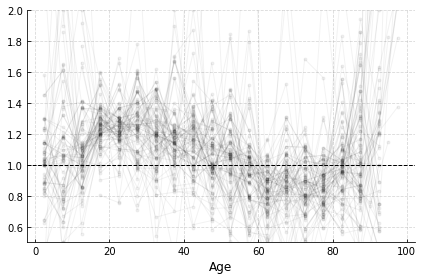

In [59]:
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig, ax = plt.subplots()
ax.axhline(1, color='black', lw=1, ls='--')
mean_deltas = [1 - df[~df.isin([np.inf]).any(1)]['DeltaR'].mean() for df in results_to_plot]
#print(mean_deltas)
mean_delta = np.mean(mean_deltas)
for i, df in enumerate(results_to_plot):
    df = df[~df.isin([np.inf]).any(1)]
    df.plot(x='Age', y='R', 
            #linestyle='', linewidth=1,
            linestyle='-', linewidth=1,
            #yerr='DeltaR', capsize=3,
            marker='.',#  markersize=3,
            color = 'black',
            alpha = .05,
            #alpha = .2*(mean_deltas[i]/max(mean_deltas)),
            ylim = (.5, 2),
            ax = ax, legend=False)
plt.show()
fig.savefig(fig_out / "composite_summary.png")

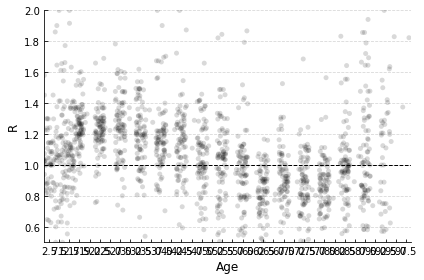

In [57]:
import seaborn as sns
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig, ax = plt.subplots()
ax.axhline(1, color='black', lw=1, ls='--')

composite = pd.concat(results_to_plot)

composite = composite[~composite.isin([np.inf]).any(1)]
sns.stripplot(
    x='Age', y='R', data=composite,
    #linestyle='', linewidth=1,
    #linestyle='-', linewidth=1,
    #yerr='DeltaR', capsize=3,
    #marker='.',#  markersize=3,
    #x_jitter=50,
    jitter=.5,
    color = 'black',
    alpha = .15,
    #alpha = .2*(mean_deltas[i]/max(mean_deltas)),
    #ylim = (.5, 2),
    ax = ax, 
#    legend=False
)
ax.set_ylim(.5, 2)
plt.show()
fig.savefig(fig_out / "composite_summary_2.png")